In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


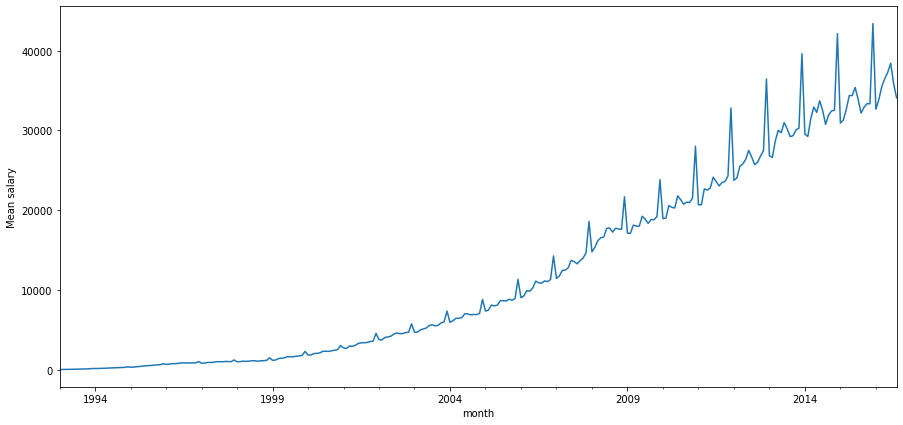

In [3]:
plt.figure(figsize(15,7))
data['WAG_C_M'].plot()
plt.ylabel('Mean salary')
pylab.show()

## 1. Визуальный анализ ряда

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

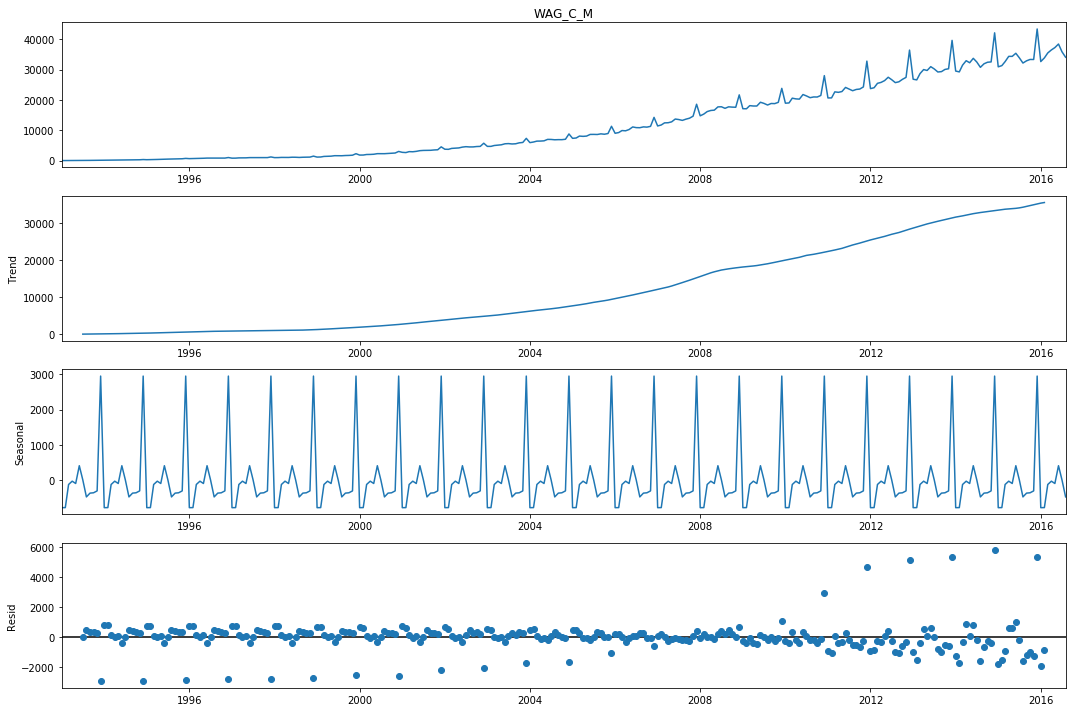

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1])

Видим, что есть сезонность и тренд, а так же что ряд не стационарный по критерию Дики-Фуллера

## 2. Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


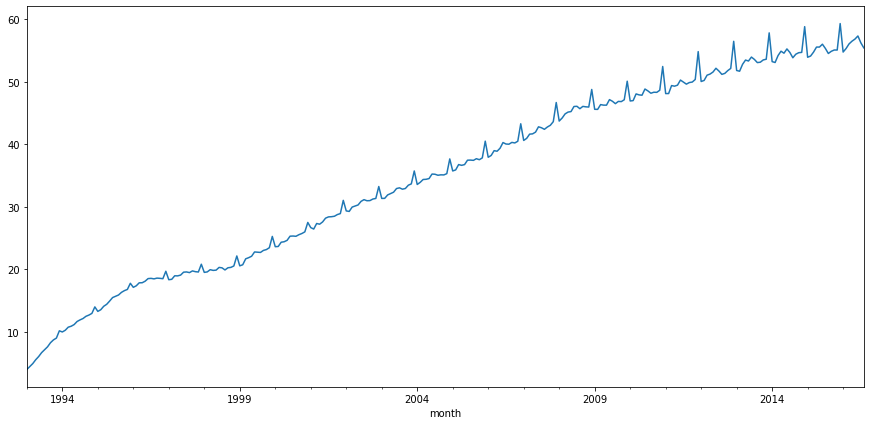

In [5]:
data['box'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize(15,7))
data['box'].plot()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['box'])[1])

## 3. Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

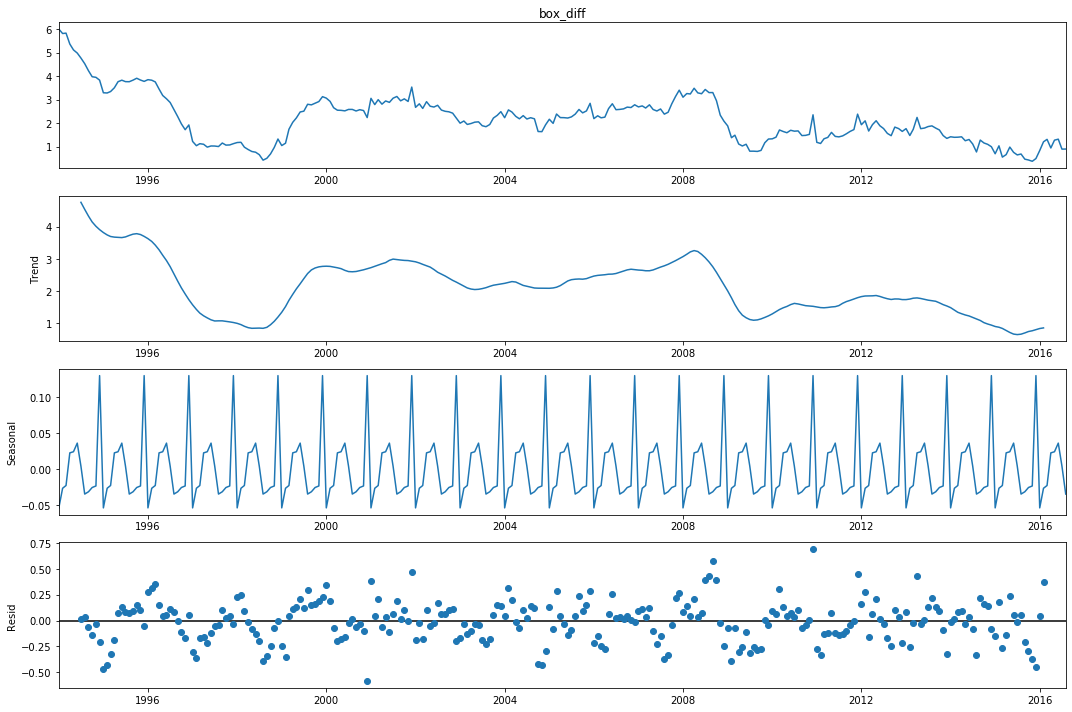

In [6]:
data['box_diff'] = data['box'] - data['box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['box_diff'].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['box_diff'].dropna())[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда, проверим будет ли лучше если продифференцировать ещё раз

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

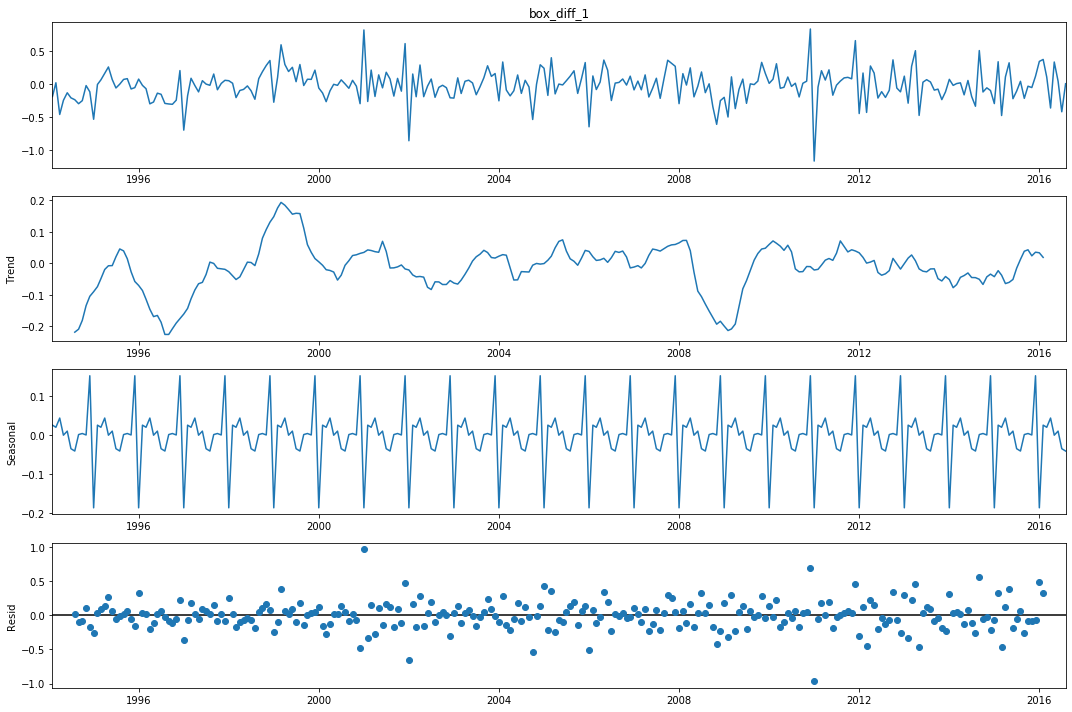

In [7]:
data['box_diff_1'] = data['box_diff'] - data['box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['box_diff_1'].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['box_diff_1'].dropna())[1])

Стало лучше, можно уверенно сказать, что ряд стационнарный

## 4. Выбор начальных приближений для p, q, P, Q

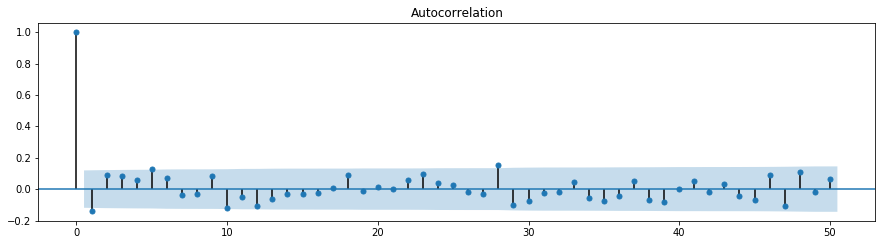

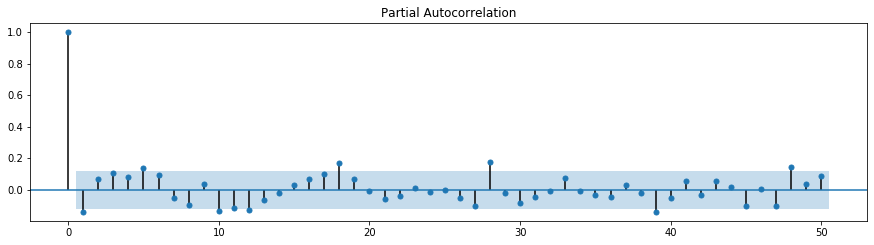

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['box_diff_1'].dropna().values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['box_diff_1'].dropna().values.squeeze(), lags=50, ax=ax)
pylab.show()

q = 1, Q = 0, p = 5, P = 1

In [9]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 4.77 s, sys: 38.1 ms, total: 4.81 s
Wall time: 4.92 s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
23  (5, 1, 1, 0) -5.260133
15  (3, 1, 1, 0) -4.995859
21  (5, 0, 1, 0) -4.545935
19  (4, 1, 1, 0) -3.975974
11  (2, 1, 1, 0) -3.884138


In [13]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, [], 12)   Log Likelihood                  10.630
Date:                             Fri, 28 Aug 2020   AIC                             -5.260
Time:                                     16:15:49   BIC                             23.557
Sample:                                 01-01-1993   HQIC                             6.310
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2017      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      

## 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.296189
Критерий Дики-Фуллера: p=0.000000


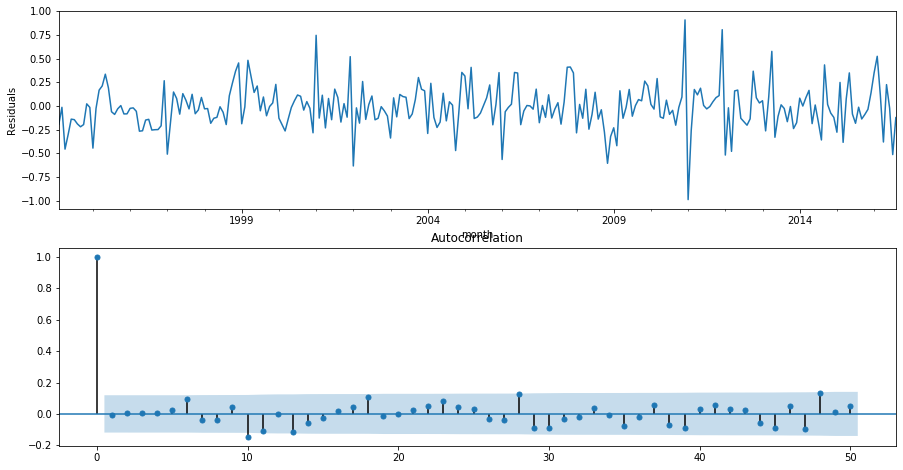

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

По критерию Стьюдента получается, что остатки несмещены.
По критерию Дики-Фуллера получается, что остатки стационарны.

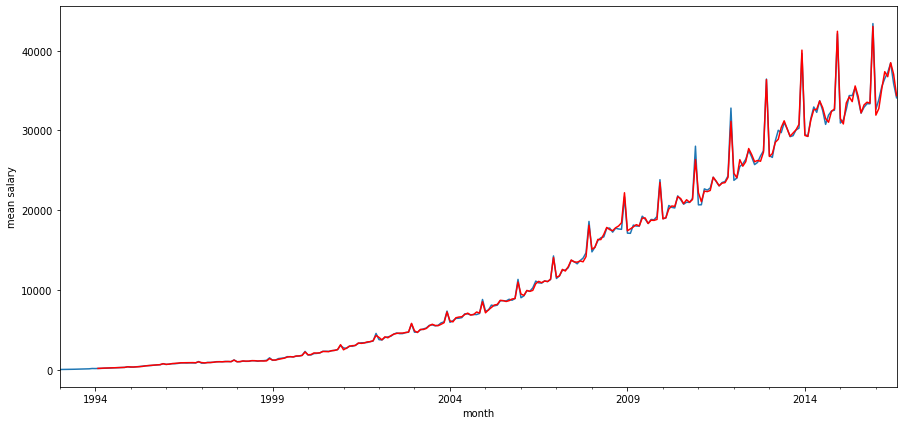

In [15]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data['WAG_C_M'].plot()
data['model'][13:].plot(color='r')
plt.ylabel('mean salary')
pylab.show()

Неплохо описывает

## 7. Прогнозирование с помощью финальной модели.

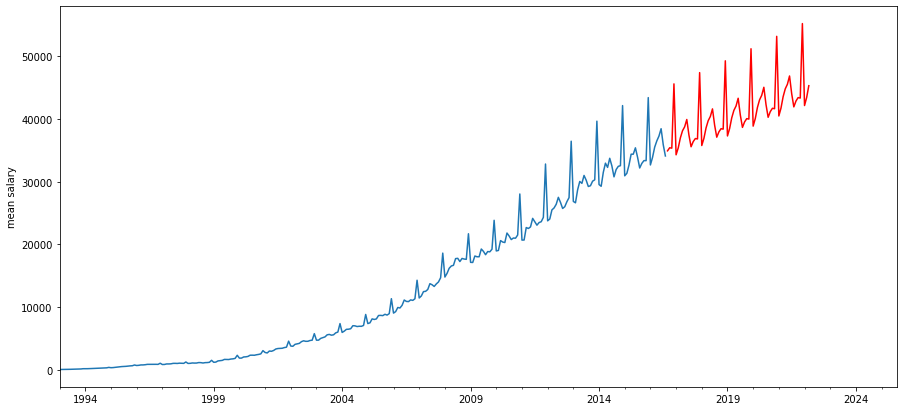

In [19]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36*3)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=40), lmbda)

plt.figure(figsize(15,7))
data2['WAG_C_M'].plot()
data2['forecast'].plot(color='r')
plt.ylabel('mean salary')
pylab.show()